In [234]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

pd.set_option('display.max_columns', 500)


sns.set(style="white")

In [235]:
# reading the merged file. 

df =pd.read_csv("/Users/jj/PycharmProjects/little_ds_problem/src/merged.vcf", sep="\t", index_col=0)

In [236]:
# dropping duplicated rows after merging.
df = df.drop_duplicates()

# Looking at the heat map, T_QQ, ti_NS and ti_HS is None and FILTER is always PASS. 
# tf_GT == 

df = df.drop(["ti_NS", 'ti_HS', 'T_QQ', 'FILTER', 'tf_GT', 'T_GT', 'Q_GT'], axis=1)




# Drop all rows with multiple alternate allele observations.

def get_mult_alt(row):
    if len(row.ALT.split(",")) > 1:
        return 1
    else:
        return 0
    

df["mult_alt_allele"] = df.apply(get_mult_alt, axis=1)


# Q_BD is our Target.  Looking at this, there is only two option.  FP or TP. 
# I will make another column called target FP = 0 or FALSE, TP = 1 or TRUE.

def get_target(row):
    if row.Q_BD == 'FP':
        return 0
    elif row.Q_BD == 'TP':
        return 1 
   

df["target"] = df.apply(get_target, axis=1)

# excluding multiple alt allele
df = df[df.mult_alt_allele != 1]


# pandas somehow defaulted some columns as object type, I am casting them to float. 
obj_df = df.select_dtypes(include=['object']).copy()
fs = ['tf_AO','tf_SAF','tf_SAR','tf_FAO','tf_AF','tf_FSAF','tf_FSAR','ti_AO','ti_SAF','ti_SAR','ti_FAO', 'ti_AF', 'ti_FSAF', 'ti_FSAR', 'ti_RBI', 'ti_LEN', 'ti_HRUN', 'ti_RBI', 'ti_FWDB',
       'ti_REVB', 'ti_REFB', 'ti_VARB', 'ti_SSSB', 'ti_SSEN', 'ti_SSEP',
       'ti_STB', 'ti_STBP', 'ti_PB', 'ti_PBP', 'ti_MLLD', 'ti_OPOS' ]

for f in fs:
    s = obj_df[f]
    df[f] = pd.to_numeric(s, downcast='float')

In [237]:
# Convert categorical values into continuous variables. 
# This is very painful part when you have 76 columns 

df

In [238]:
# Look at the correlation matrix and figure out which fields are not important. 
# keep tf_GQ
# drop 'tf_DP', 'tf_RO', 'tf_SRF', 'tf_SRR'

df = df.drop(['tf_DP', 'ti_DP', 'tf_RO', 'tf_SRF', 'tf_SRR', 'ti_OPOS'], axis=1)

corr_matrix = df.corr()

high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y] 

high_corr_var







# df[["tf_GQ",'tf_FSRF']]

[('POS', 'ti_OPOS'),
 ('QUAL', 'tf_AO'),
 ('QUAL', 'tf_SAF'),
 ('QUAL', 'tf_SAR'),
 ('QUAL', 'tf_FAO'),
 ('QUAL', 'tf_FSAF'),
 ('QUAL', 'tf_FSAR'),
 ('QUAL', 'ti_AO'),
 ('QUAL', 'ti_SAF'),
 ('QUAL', 'ti_SAR'),
 ('QUAL', 'ti_FAO'),
 ('QUAL', 'ti_FSAF'),
 ('QUAL', 'ti_FSAR'),
 ('QUAL', 'Q_QQ'),
 ('tf_GQ', 'tf_FRO'),
 ('tf_GQ', 'tf_FSRF'),
 ('tf_GQ', 'tf_FSRR'),
 ('tf_GQ', 'ti_FRO'),
 ('tf_GQ', 'ti_FSRF'),
 ('tf_GQ', 'ti_FSRR'),
 ('tf_AO', 'tf_SAF'),
 ('tf_AO', 'tf_SAR'),
 ('tf_AO', 'tf_FDP'),
 ('tf_AO', 'tf_FAO'),
 ('tf_AO', 'tf_FSAF'),
 ('tf_AO', 'tf_FSAR'),
 ('tf_AO', 'ti_AO'),
 ('tf_AO', 'ti_SAF'),
 ('tf_AO', 'ti_SAR'),
 ('tf_AO', 'ti_FDP'),
 ('tf_AO', 'ti_FAO'),
 ('tf_AO', 'ti_FSAF'),
 ('tf_AO', 'ti_FSAR'),
 ('tf_AO', 'Q_QQ'),
 ('tf_SAF', 'tf_FAO'),
 ('tf_SAF', 'tf_FSAF'),
 ('tf_SAF', 'ti_AO'),
 ('tf_SAF', 'ti_SAF'),
 ('tf_SAF', 'ti_FAO'),
 ('tf_SAF', 'ti_FSAF'),
 ('tf_SAF', 'Q_QQ'),
 ('tf_SAR', 'tf_FAO'),
 ('tf_SAR', 'tf_FSAR'),
 ('tf_SAR', 'ti_AO'),
 ('tf_SAR', 'ti_SAR'),
 ('tf_SAR

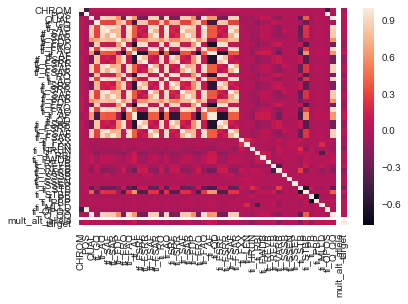

In [239]:
corr = df.corr()
ax = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


fig = ax.get_figure()
fig.savefig('heatmap.png')

In [267]:
t_df = df.select_dtypes(exclude=['object']).copy()



t_df = t_df.dropna(how='any')


# find all nan values in the df 
# pd.isnull(t_df).any()

# print(t_df[pd.isnull(t_df).any(axis=1)].head())


# print(len(t_df[pd.isnull(t_df).any(axis=1)]))

In [269]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

test_df = t_df
X = test_df.drop(['target'], axis=1)
y = test_df.target

X.shape

(50638, 49)

In [271]:
# use feature importance to estimate the importnace of features...  It seems, none of them are even 10 percent importance.  I am going to see if PCA could be better. 


clf = ExtraTreesClassifier()
clf = clf.fit(X, y)
print(clf.feature_importances_)  
# 
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape

[ 0.04005331  0.04046249  0.02379085  0.02323752  0.02016163  0.02226604
  0.02259863  0.02226076  0.01757685  0.02108213  0.02339075  0.01525377
  0.01436169  0.02190172  0.02260367  0.01738007  0.02151459  0.01741995
  0.01702117  0.02172661  0.02157479  0.02143001  0.01719571  0.02222196
  0.03037828  0.02891604  0.01738496  0.01611821  0.02207595  0.02209001
  0.01592291  0.00597771  0.02724654  0.02418046  0.02431131  0.02536651
  0.02066561  0.02899468  0.0240651   0.00043066  0.0004161   0.02632415
  0.01698776  0.00235921  0.00216226  0.0277059   0.03719831  0.02423472
  0.        ]


(50638, 31)

In [ ]:
from sklearn.decomposition import PCA













